Imports

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
from pathlib import Path

from sklearn.linear_model import LogisticRegression, LinearRegression
from causallib.estimation import IPW, MarginalOutcomeEstimator

import seaborn as sns
import seaborn.objects as so

from analysis_script import *
from bicause_tree import BICauseTree, crump

Model and hyperparameters configuration

In [14]:
dataset = 'twins'
file_name =None
run_multiprocessing = False

data, x, t, y = get_data(dataset)
n_bootstraps = 50
test_size = 0.5
multiple_hypothesis_test_method = 'holm'
positivity_filtering_method = crump
positivity_filtering_kwargs = {}

models_to_compare = {
    "BICauseTree(Marginal)": BICauseTree(
        min_treat_group_size=2, asmd_threshold_split=0.1, max_depth=10,
        individual=False,
        multiple_hypothesis_test_alpha=0.05,
        multiple_hypothesis_test_method=multiple_hypothesis_test_method,
        positivity_filtering_method=positivity_filtering_method,
        positivity_filtering_kwargs=positivity_filtering_kwargs,
        outcome_model=MarginalOutcomeEstimator(learner=None)
    ),
    "BICauseTreeRandomSplit(Marginal)": BICauseTree(
        min_treat_group_size=2, asmd_threshold_split=0.1, max_depth=10,
        individual=False,
        multiple_hypothesis_test_alpha=0.05,
        multiple_hypothesis_test_method=multiple_hypothesis_test_method,
        positivity_filtering_method=positivity_filtering_method,
        positivity_filtering_kwargs=positivity_filtering_kwargs,
        outcome_model=MarginalOutcomeEstimator(learner=None),
        split_on_random_feature=True
    ),
    "Ground truth": (data['y1'], data['y0']),
    # "IPW(LR)": IPW(LogisticRegression(solver='saga', penalty='none', max_iter=500)),
    # "IPW(GBT)": IPW(GradientBoostingClassifier(random_state=0)),
    # "Marginal": MarginalOutcomeEstimator(learner=None)
}

outcome_names = ['BICauseTree(Marginal)', "BICauseTreeRandomSplit(Marginal)"]
tree_names = ['BICauseTree(Marginal)', "BICauseTreeRandomSplit(Marginal)"]
pscore_names = ['BICauseTree(Marginal)', "BICauseTreeRandomSplit(Marginal)"]
tree_filter_name = ['BICauseTree(Marginal)']  # , "BICauseTreeRandomSplit(Marginal)"]

# Note: Causal Tree and Causal Forest are not implemented here as their API differs
# You may generate a nested list of ATE for the different bootstraps using the econml package
# with the following code for the models:
# from econml.dml import CausalForestDML
# 'Causal Tree': dml.CausalForestDML(n_estimators=50, inference=False)
# 'Causal Forest': dml.CausalForestDML(n_estimators=1, subforest_size=1, inference=False)


Model fitting

In [16]:
effects, fitted_models, bootstrap_matrix = bootstrap_fit_effect(
    models_to_compare, 
    x, t, y, 
    tree_names,
    n_bootstraps=n_bootstraps, 
    test_size=test_size, 
    run_multiprocessing=run_multiprocessing
)

In [22]:
pscore_fitted_models = {id: model for id, model in fitted_models.items() if id[0] in pscore_names}
outcome_fitted_models = {id: model for id, model in fitted_models.items() if id[0] in outcome_names}
tree_fitted_models = {id: model for id, model in fitted_models.items() if id[0] in tree_names}
tree_unfitted_models = {id: model for id, model in models_to_compare.items() if id in tree_names}
filtering_tree_models = {id: model for id, model in fitted_models.items() if id[0] in tree_filter_name}

if positivity_filtering_method is not None:
    positivity_matrix = generate_violating_matrix(filtering_tree_models, x)
else:
    positivity_matrix = pd.DataFrame(data=np.ones((len(x), len(filtering_tree_models))), index=x.index)
# positivity_matrix has non violating samples as 1 rest 0

positivity_boot_mask = np.multiply(bootstrap_matrix, positivity_matrix)
# positivity_boot_mask hqs test & non violating samples marked as 1 rest 0

Comparing effect estimation biases across models 

In [32]:
filtered_effects = compute_filtered_effect(
    x, t, y, 
    bootstrap_matrix, 
    positivity_matrix, 
    fitted_models, models_to_compare
)

In [33]:
filtered_effect_diff_data = box_plot_effect_difference_data(
    models_to_compare, filtered_effects
)
filtered_effect_diff_data
# filtered_effect_diff_plot = box_plot_effect_difference_plot(
#     filtered_effect_diff_data, plot_test=True, path=None
# )

,Phase,Model,Estimated ATE
0,Test,BICauseTree(Marginal),0.022309
0,Test,BICauseTreeRandomSplit(Marginal),0.035656
0,Train,BICauseTree(Marginal),0.046583
0,Train,BICauseTreeRandomSplit(Marginal),0.065374
1,Test,BICauseTree(Marginal),0.039735
...,...,...,...
48,Train,BICauseTreeRandomSplit(Marginal),0.059748
49,Test,BICauseTree(Marginal),0.043225
49,Test,BICauseTreeRandomSplit(Marginal),0.056360
49,Train,BICauseTree(Marginal),0.034600


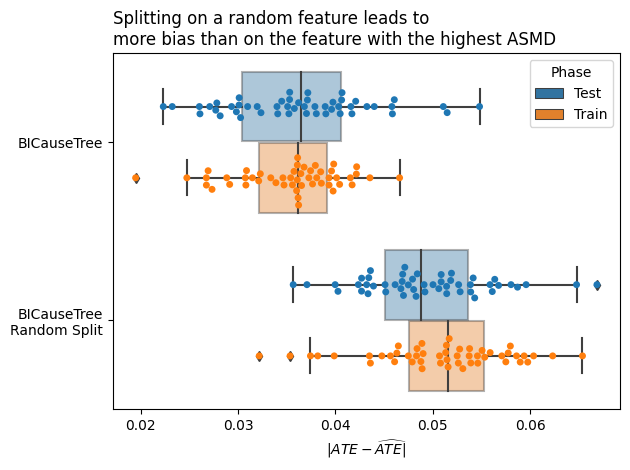

In [70]:
fig, ax = plt.subplots()
sns.boxplot(
    data=filtered_effect_diff_data, 
    y="Model", 
    x="Estimated ATE", 
    hue="Phase", 
    boxprops=dict(alpha=.4),
    # color="grey",
    ax=ax,
)
sns.swarmplot(
    data=filtered_effect_diff_data, 
    y="Model", 
    x="Estimated ATE", 
    hue="Phase", 
    dodge=True,
    legend=False,
    ax=ax,
)
# ax.legend(fontsize=12)
# ax.tick_params(axis='both', which='both', labelsize=12)
# ax.set_xlim(0, ax.get_xlim()[1])
ax.set_yticklabels(["BICauseTree", "BICauseTree\nRandom Split"])
ax.set_ylabel(None)
ax.set_xlabel(r"$ \vert ATE - \widehat{ATE} \vert $")
ax.set_title(
    "Splitting on a random feature leads to \nmore bias than on the feature with the highest ASMD",
    loc='left',
)
fig.tight_layout()

In [72]:
fig_dir = Path("figures")
for ext in ["svg", "png", "pdf"]:
    fig.savefig(fig_dir / f"random_split_bias.{ext}")
filtered_effect_diff_data.to_csv(fig_dir / "random_split_bias.csv")

Inspect ASMD:

In [81]:
from bicause_tree import PropensityStartaficationPropensity
from analysis_script import generate_weighted_asmds_leaf
from causallib.estimation import IPW

In [82]:
models_to_compare = {
    "BICauseTree(Marginal)": IPW(PropensityStartaficationPropensity(
        min_treat_group_size=2, asmd_threshold_split=0.1, max_depth=10,
        positivity_filtering_method=positivity_filtering_method,
        positivity_filtering_kwargs=positivity_filtering_kwargs,
    )),
    "BICauseTreeRandomSplit(Marginal)": IPW(PropensityStartaficationPropensity(
        min_treat_group_size=2, asmd_threshold_split=0.1, max_depth=10,
        positivity_filtering_method=positivity_filtering_method,
        positivity_filtering_kwargs=positivity_filtering_kwargs,
        split_on_random_feature=True
    )),
}

In [84]:
asmd_res = {}
for model_name, ipw_model in models_to_compare.items():
    asmd = generate_weighted_asmds_leaf(
        x, t,
        bootstrap_matrix,
        ipw_model,
    )
    asmd_res[model_name] = asmd

In [93]:
asmd_res = pd.concat(asmd_res, names=["model"]).reset_index("model").reset_index(drop=True)
asmd_res

,model,bootstrap,covariate,weighted
0,BICauseTree(Marginal),0,eclamp,0.054146
1,BICauseTree(Marginal),0,gestatcat1,0.000721
2,BICauseTree(Marginal),0,gestatcat2,0.008734
3,BICauseTree(Marginal),0,gestatcat3,0.006340
4,BICauseTree(Marginal),0,gestatcat4,0.031893
...,...,...,...,...
7495,BICauseTreeRandomSplit(Marginal),49,data_year,0.060002
7496,BICauseTreeRandomSplit(Marginal),49,crace,0.059102
7497,BICauseTreeRandomSplit(Marginal),49,birmon,0.005266
7498,BICauseTreeRandomSplit(Marginal),49,dtotord_min,0.009920


In [95]:
fig_dir = Path("figures")
asmd_res.to_csv(fig_dir / "random_split_asmd.csv")

In [98]:
asmd = asmd_res.set_index(["model", "bootstrap", "covariate"])["weighted"]

In [103]:
asmd.xs(("BICauseTree(Marginal)", 0))
asmd.groupby(["model", "bootstrap"]).max()  # agg(["idxmax", "max"])

model                             bootstrap
BICauseTree(Marginal)             0            0.070235
                                  1            0.094593
                                  2            0.083731
                                  3            0.069951
                                  4            0.076016
                                                 ...   
BICauseTreeRandomSplit(Marginal)  45           0.121027
                                  46           0.151478
                                  47           0.123195
                                  48           0.142025
                                  49           0.138397
Name: weighted, Length: 100, dtype: float64

Text(0.0, 1.0, 'Splitting on a random feature leads to \nmore imbalance than on the feature with the highest ASMD')

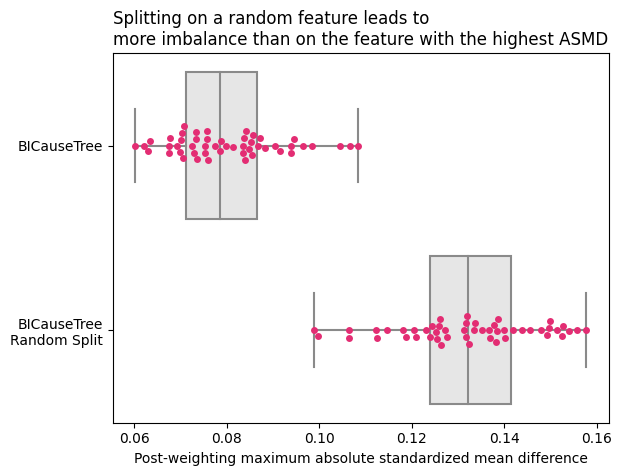

In [107]:
plot_data = asmd.groupby(["model", "bootstrap"]).max().reset_index()

fig, ax = plt.subplots()
sns.boxplot(
    data=plot_data, 
    y="model", 
    x="weighted", 
    # hue="model",
    dodge=False,
    # boxprops=dict(alpha=.4),
    color="0.9",
    ax=ax,
)
sns.swarmplot(
    data=plot_data, 
    y="model", 
    x="weighted", 
    # hue="model",  
    dodge=False,
    legend=False,
    color="#e32d73",
    ax=ax,
)
# ax.legend(fontsize=12)
# ax.tick_params(axis='both', which='both', labelsize=12)
# ax.set_xlim(0, ax.get_xlim()[1])

ax.set_yticklabels(["BICauseTree", "BICauseTree\nRandom Split"])
ax.set_ylabel(None)
ax.set_xlabel(r"Post-weighting maximum absolute standardized mean difference")
ax.set_title(
    "Splitting on a random feature leads to \nmore imbalance than on the feature with the highest ASMD",
    loc='left',
)
# fig.tight_layout()

In [108]:
for ext in ["svg", "png", "pdf"]:
    fig.savefig(fig_dir / f"random_split_asmd.{ext}")

Plot both

In [110]:
import pandas as pd
import seaborn as sns
from pathlib import Path

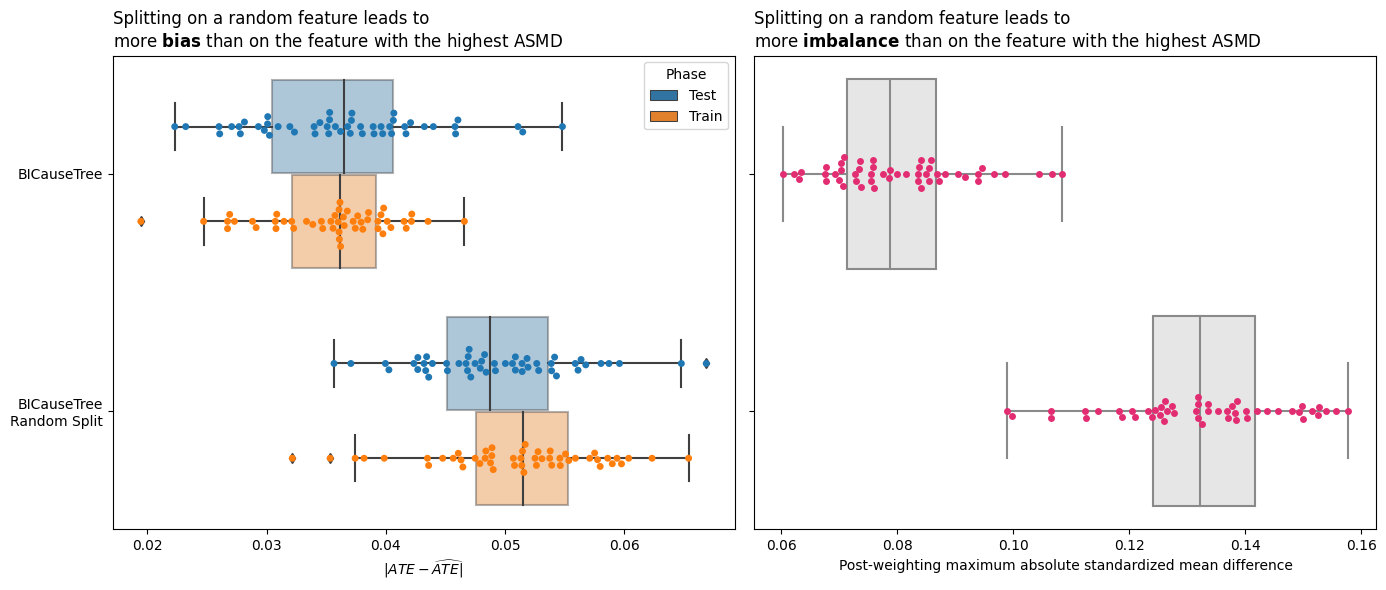

In [124]:
bias_data = pd.read_csv(Path("figures") / "random_split_bias.csv")
asmd_data = pd.read_csv(Path("figures") / "random_split_asmd.csv")
asmd_data = asmd_data.groupby(["model", "bootstrap"]).max().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Bias plot
sns.boxplot(
    data=bias_data, 
    y="Model", 
    x="Estimated ATE", 
    hue="Phase", 
    boxprops=dict(alpha=.4),
    # color="grey",
    ax=axes[0],
)
sns.swarmplot(
    data=bias_data, 
    y="Model", 
    x="Estimated ATE", 
    hue="Phase", 
    dodge=True,
    legend=False,
    ax=axes[0],
)
axes[0].set_yticklabels(["BICauseTree", "BICauseTree\nRandom Split"])
axes[0].set_ylabel(None)
axes[0].set_xlabel(r"$ \vert ATE - \widehat{ATE} \vert $")
axes[0].set_title(
    "Splitting on a random feature leads to \nmore $ \\bf{bias} $ than on the feature with the highest ASMD",
    loc='left',
)
# fig.tight_layout()

# ASMD plot:
sns.boxplot(
    data=asmd_data, 
    y="model", 
    x="weighted", 
    # hue="model",
    dodge=False,
    # boxprops=dict(alpha=.4),
    color="0.9",
    ax=axes[1],
)
sns.swarmplot(
    data=asmd_data, 
    y="model", 
    x="weighted", 
    # hue="model",  
    dodge=False,
    legend=False,
    color="#e32d73",
    ax=axes[1],
)
axes[1].set_yticklabels(["BICauseTree", "BICauseTree\nRandom Split"])
axes[1].set_ylabel(None)
axes[1].set_xlabel(r"Post-weighting maximum absolute standardized mean difference")
axes[1].set_title(
    "Splitting on a random feature leads to \nmore $ \\bf{imbalance} $ than on the feature with the highest ASMD",
    loc='left',
);
fig.tight_layout();

In [125]:
for ext in ["svg", "png", "pdf"]:
    fig.savefig(fig_dir / f"random_split.{ext}")

Plot tree on entire dataset

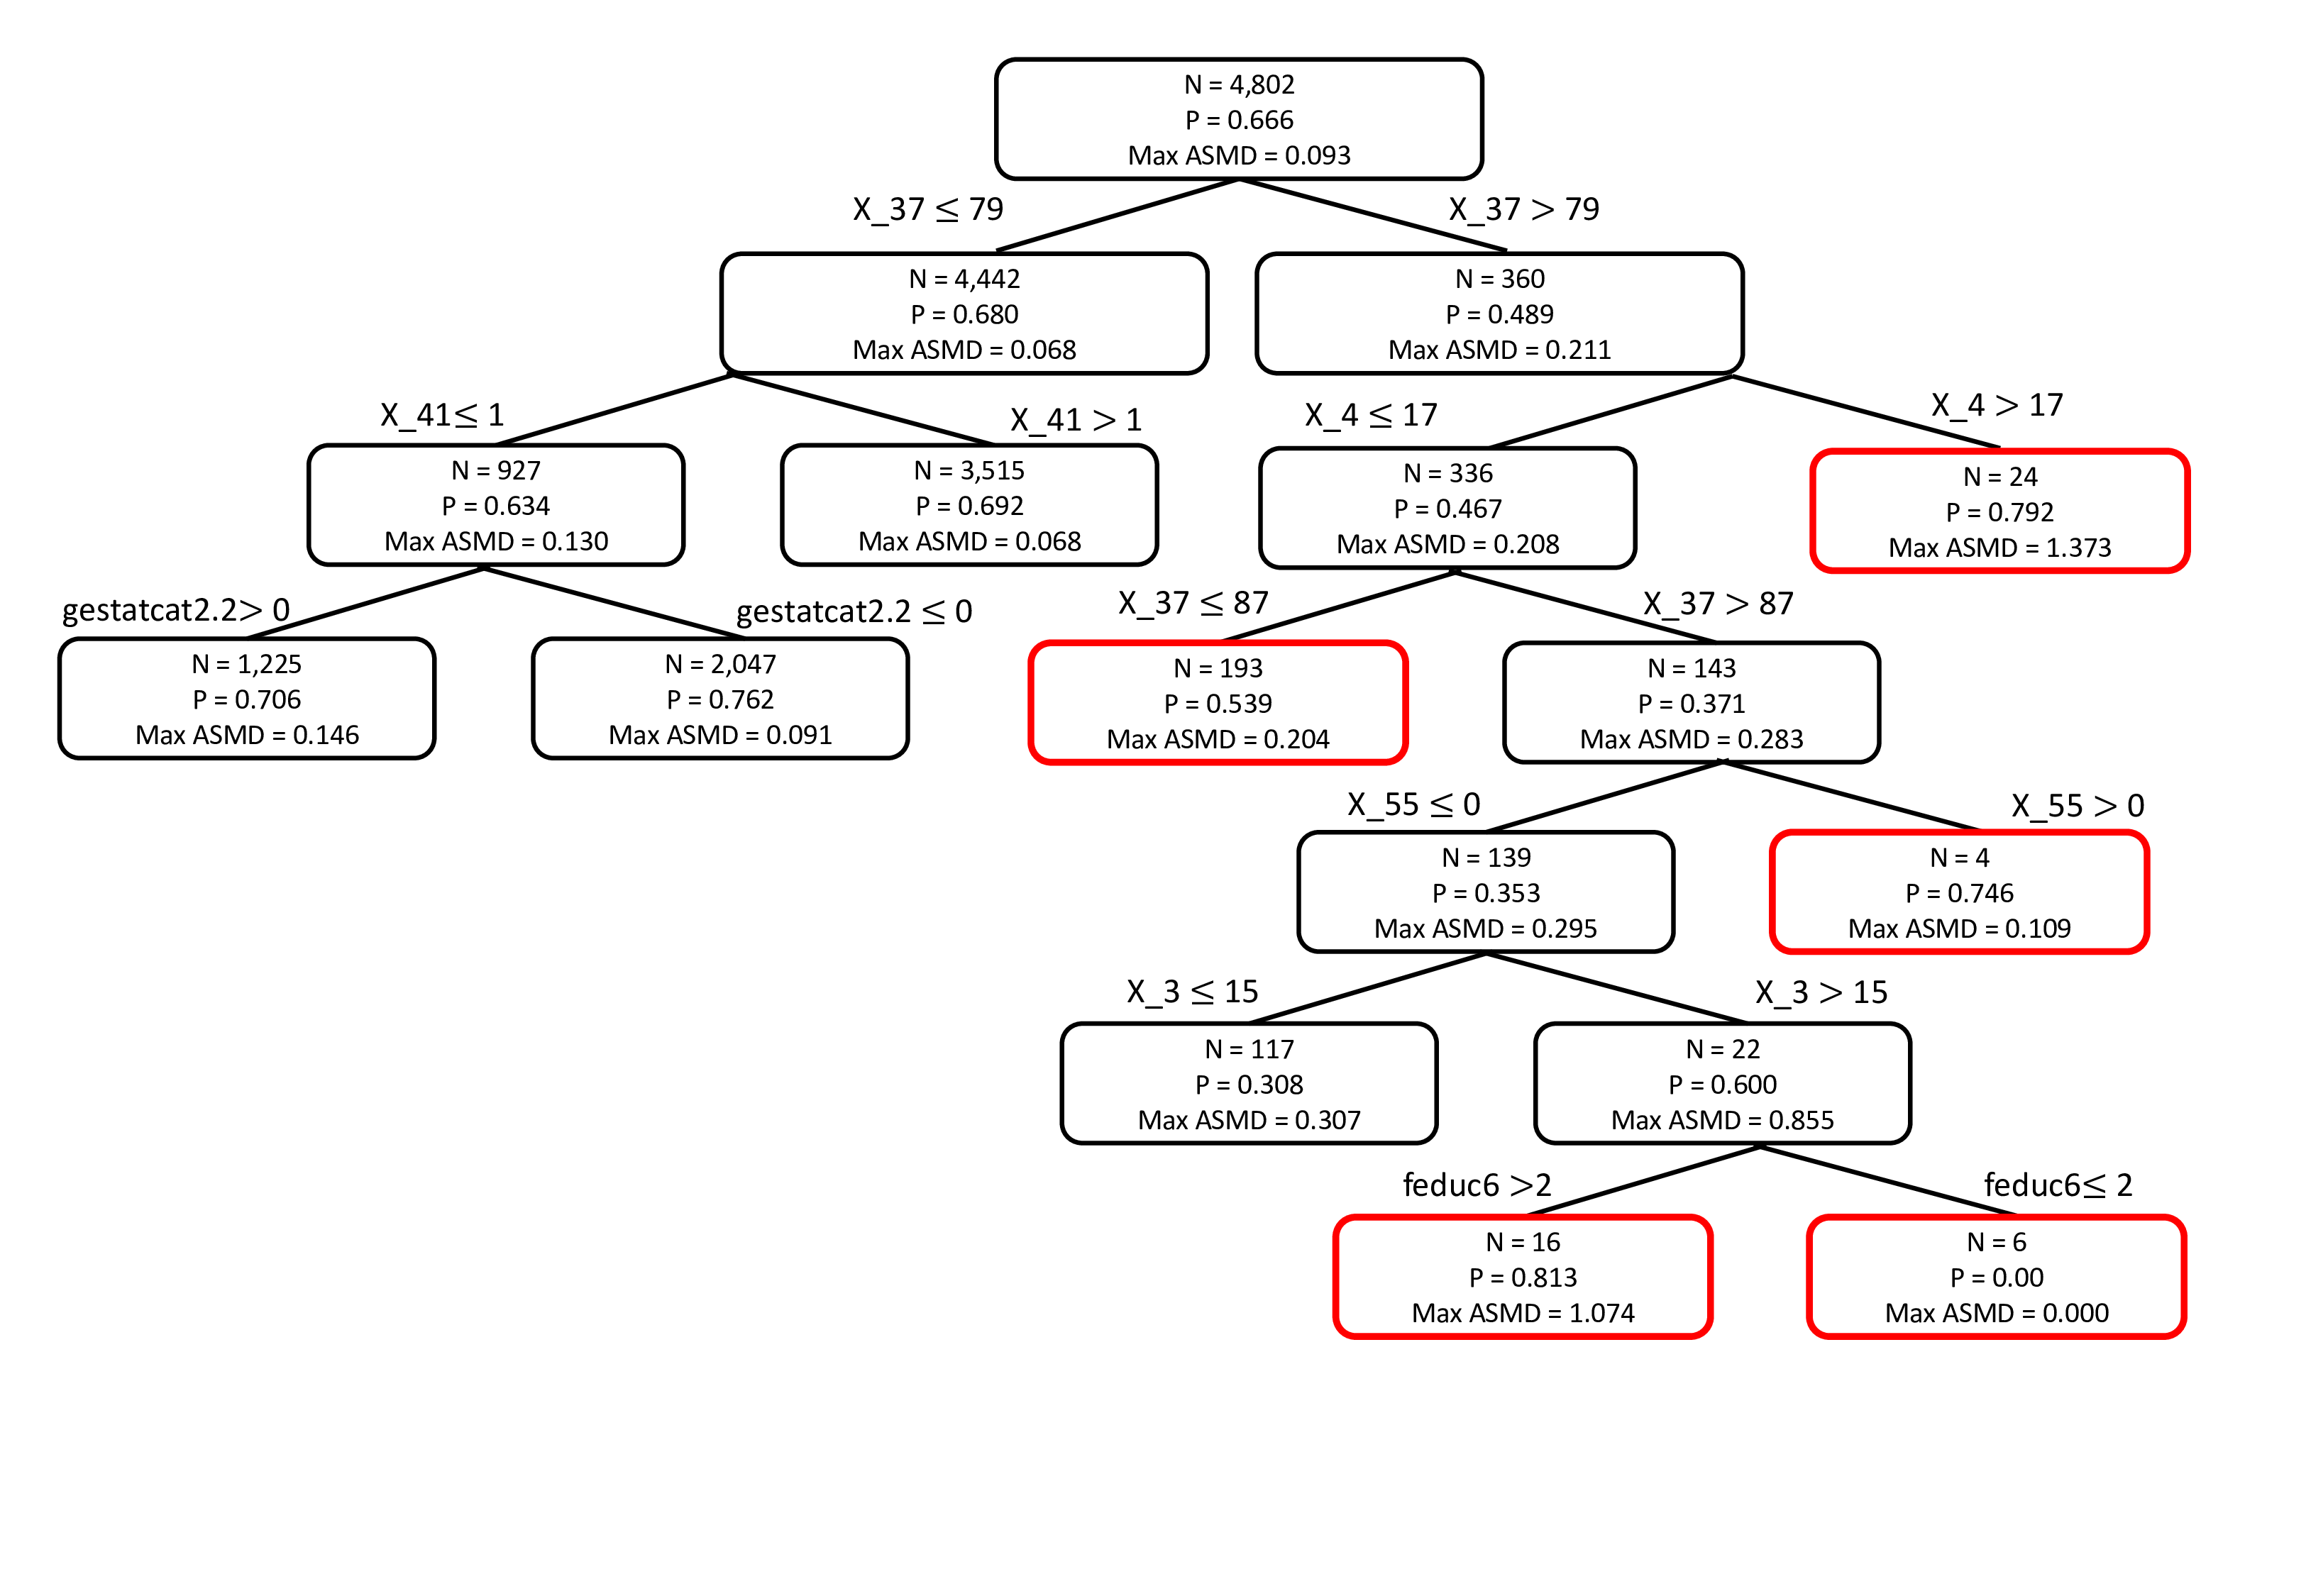

In [11]:
entire_fitted_model = {"BICauseTree(Marginal)": BICauseTree(min_treat_group_size=2, asmd_threshold_split=0.1, max_depth=10,
                                          individual=False,
                                          multiple_hypothesis_test_alpha=0.05,
                                          multiple_hypothesis_test_method=multiple_hypothesis_test_method,
                                          positivity_filtering_method=positivity_filtering_method,
                                          positivity_filtering_kwargs=positivity_filtering_kwargs,
                                          outcome_model=MarginalOutcomeEstimator(learner=None)
                                          )}
entire_fitted_model["BICauseTree(Marginal)"].fit(x, t, y)
save_tree_explains = save_tree_explains(x, t, entire_fitted_model, path=None)
